<a href="https://colab.research.google.com/github/jiheeyy/data259/blob/main/IP/ethics_IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Attribute Manipulation
Main code reference:
https://github.com/danielroich/PTI

## PyDrive activation Used for bypassing Google Drive download rate limit

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True #@param {type:"boolean"}  

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

## Step 1 - Install Packages required by PTI

In [ ]:
## Other packages are already builtin in the Colab interpreter
!pip install wandb
!pip install lpips

## Used for faster inference of StyleGAN by enabling C++ code compilation

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=f1e6140792e3992d7ca491ef6b12448a5ead8e0707a1a17eed1f71bfaa132dba
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 7.2 MB/s eta 0:00:00
--2023-05-16 04:32:14--  https://github.com/ninja-build/ninja/releas

## Step 2 - Download Pretrained models

In [ ]:
import os
os.chdir('/content')
CODE_DIR = 'PTI'

!git clone https://github.com/danielroich/PTI.git $CODE_DIR

os.chdir(f'./{CODE_DIR}')

import sys
import pickle
import numpy as np
from PIL import Image
import torch
from configs import paths_config, hyperparameters, global_config
from utils.align_data import pre_process_images
from scripts.run_pti import run_PTI
from IPython.display import display
import matplotlib.pyplot as plt
from scripts.latent_editor_wrapper import LatentEditorWrapper

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
os.makedirs(save_path, exist_ok=True)

Cloning into 'PTI'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 331 (delta 60), reused 52 (delta 49), pack-reused 241
Receiving objects: 100% (331/331), 13.55 MiB | 17.54 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [ ]:
## Download pretrained StyleGAN on FFHQ 1024x1024
downloader.download_file("125OG7SMkXI-Kf2aqiwLLHyCvSW-gZk3M", os.path.join(save_path, 'ffhq.pkl'))

## Download Dlib tool for alingment, used for preprocessing images before PTI
downloader.download_file("1xPmn19T6Bdd-_RfCVlgNBbfYoh1muYxR", os.path.join(save_path, 'align.dat'))

## Step 3 - Configuration Setup

In [ ]:
image_dir_name = 'image'

## If set to true download desired image from given url. If set to False, assumes you have uploaded personal image to
## 'image_original' dir
use_image_online = True
image_name = 'personal_image'
use_multi_id_training = False
global_config.device = 'cuda'
paths_config.e4e = '/content/PTI/pretrained_models/e4e_ffhq_encode.pt'
paths_config.input_data_id = image_dir_name
paths_config.input_data_path = f'/content/PTI/{image_dir_name}_processed'
paths_config.stylegan2_ada_ffhq = '/content/PTI/pretrained_models/ffhq.pkl'
paths_config.checkpoints_dir = '/content/PTI/'
paths_config.style_clip_pretrained_mappers = '/content/PTI/pretrained_models'
hyperparameters.use_locality_regularization = False

## Step 4 - Preproccess Data

In [ ]:
os.makedirs(f'./{image_dir_name}_original', exist_ok=True)
os.makedirs(f'./{image_dir_name}_processed', exist_ok=True)
os.chdir(f'./{image_dir_name}_original')

In [ ]:
## Download real face image
## If you want to use your own image skip this part and upload an image/images of your choosing to image_original dir
if use_image_online:
  !wget -O personal_image.jpg https://raw.githubusercontent.com/jcpeterson/omi/main/images/39.jpg
  #!wget -O personal_image.jpg https://static01.nyt.com/images/2019/09/09/opinion/09Hunter1/09Hunter1-superJumbo.jpg ## Photo of Sarena Wiliams

--2023-05-16 04:33:49--  https://raw.githubusercontent.com/jcpeterson/omi/main/images/39.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107093 (105K) [image/jpeg]
Saving to: ‘personal_image.jpg’

personal_image.jpg  100%[===================>] 104.58K  --.-KB/s    in 0.003s  

2023-05-16 04:33:49 (37.3 MB/s) - ‘personal_image.jpg’ saved [107093/107093]



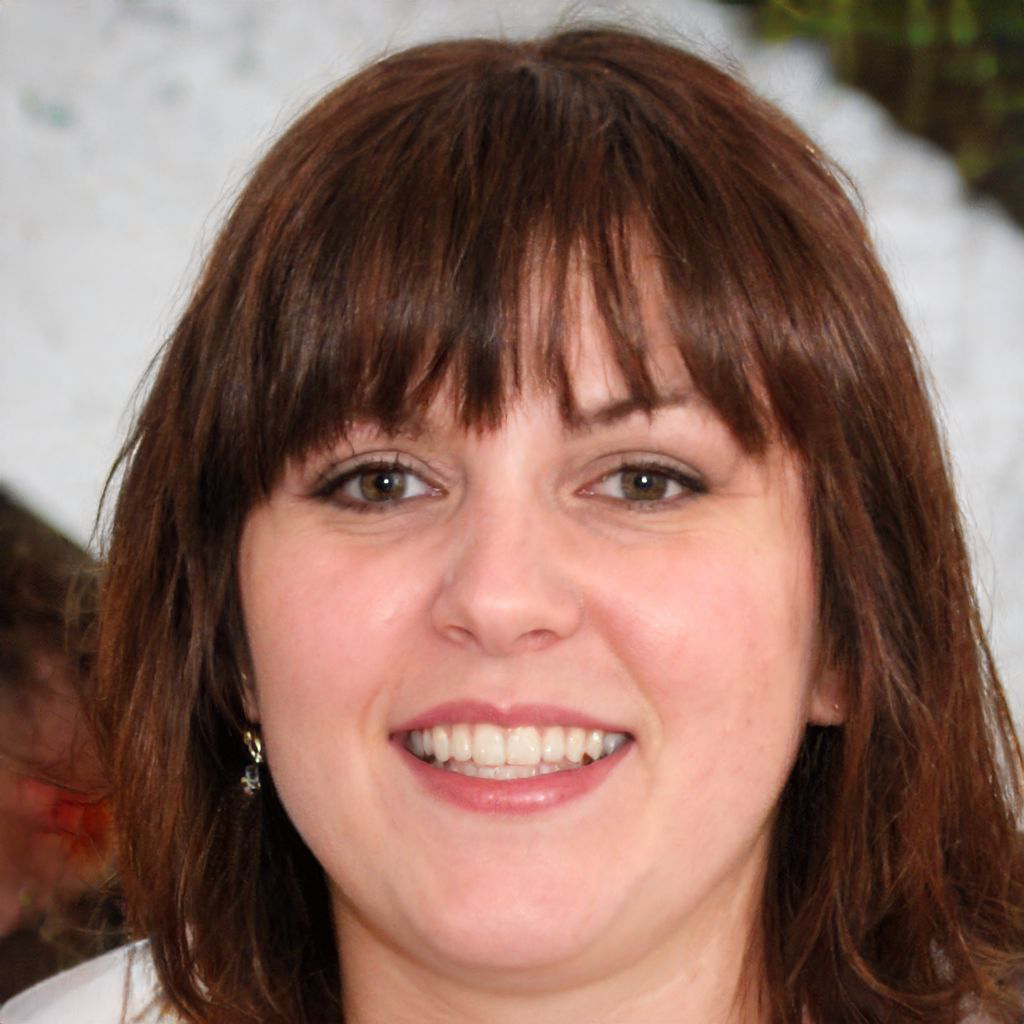

In [ ]:
original_image = Image.open(f'{image_name}.jpg')
original_image

In [ ]:
print(original_image.size)

(1024, 1024)


In [ ]:
os.chdir('/content/PTI')

In [ ]:
pre_process_images(f'/content/PTI/{image_dir_name}_original')

100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


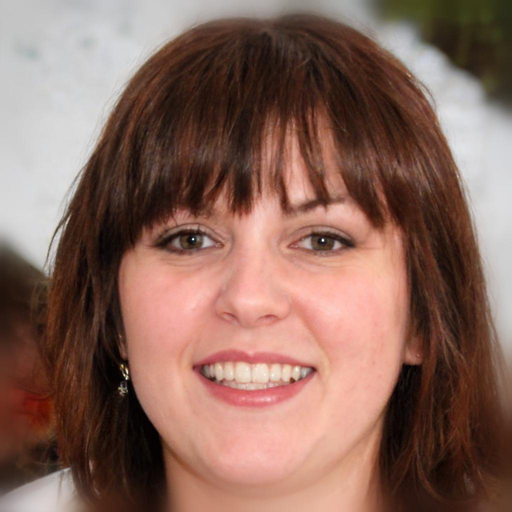

In [ ]:
aligned_image = Image.open(f'/content/PTI/{image_dir_name}_processed/{image_name}.jpeg')
aligned_image.resize((512,512))

## Step 5 - Invert images using PTI

In order to run PTI and use StyleGAN2-ada, the cwd should the parent of 'torch_utils' and 'dnnlib'.

In case use_multi_id_training is set to True and many images are inverted simultaneously
activating the regularization to keep the *W* Space intact is recommended.

If indeed the regularization is activated then please increase the number of pti steps from 350 to 450 at least
using hyperparameters.max_pti_steps

In [ ]:
os.chdir('/content/PTI')
model_id = run_PTI(use_wandb=False, use_multi_id_training=use_multi_id_training)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 308MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


  0%|          | 0/1 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.



  0%|          | 0/450 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)

100%|██████████| 450/450 [02:15<00:00,  3.33it/s]

100%|██████████| 1/1 [03:48<00:00, 228.26s/it]


## Visualize results

In [ ]:
def display_alongside_source_image(images): 
    res = np.concatenate([np.array(image) for image in images], axis=1) 
    return Image.fromarray(res) 

In [ ]:
def load_generators(model_id, image_name):
  with open(paths_config.stylegan2_ada_ffhq, 'rb') as f:
    old_G = pickle.load(f)['G_ema'].cuda()
    
  with open(f'{paths_config.checkpoints_dir}/model_{model_id}_{image_name}.pt', 'rb') as f_new: 
    new_G = torch.load(f_new).cuda()

  return old_G, new_G

In [ ]:
generator_type = paths_config.multi_id_model_type if use_multi_id_training else image_name
old_G, new_G = load_generators(model_id, generator_type)

In [ ]:
def plot_syn_images(syn_images, direction, keys): 
  drive_dir = '/content/drive/My Drive/single_sample_gan/'
  for i, img in enumerate(syn_images): 
      img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).detach().cpu().numpy()[0] 
      plt.axis('off') 
      resized_image = Image.fromarray(img,mode='RGB').resize((256,256)) 
      display(resized_image)
      # Save the Old G image to Google Drive
      if i==1:
        print('one image')
        resized_image.save(drive_dir + (f'{direction}_latent{keys}.jpg'))
      del img 
      del resized_image 
      torch.cuda.empty_cache()

If multi_id_training was used for several images.
You can alter the w_pivot index which is currently configured to 0, and then running
the visualization code again. Using the same generator on different latent codes.

In [ ]:
w_path_dir = f'{paths_config.embedding_base_dir}/{paths_config.input_data_id}'
embedding_dir = f'{w_path_dir}/{paths_config.pti_results_keyword}/{image_name}'
w_pivot = torch.load(f'{embedding_dir}/0.pt')

In [ ]:
w_pivot.shape

torch.Size([1, 18, 512])

## InterfaceGAN edits

In [ ]:
latent_editor = LatentEditorWrapper()
latents_after_edit = latent_editor.get_single_interface_gan_edits(w_pivot, [-2, 2])

In [ ]:
for direction, factor_and_edit in latents_after_edit.items():
  print(direction)

rotation
smile
age


In order to get different edits. Such as younger face or make the face smile more. Please change the factors passed to "get_single_interface_gan_edits".
Currently the factors are [-2,2]. You can pass for example: range(-3,3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Showing rotation change


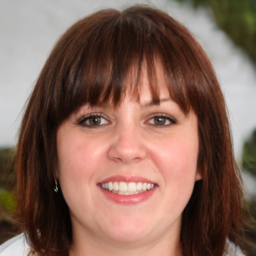

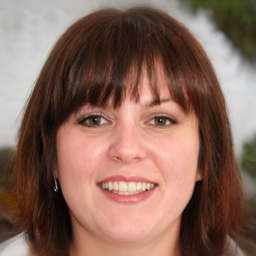

one image


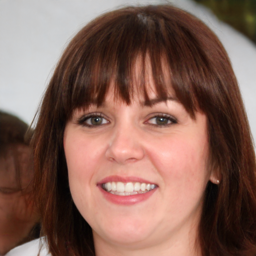

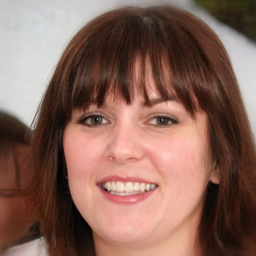

one image
Showing smile change


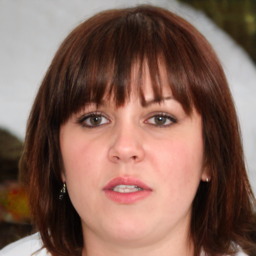

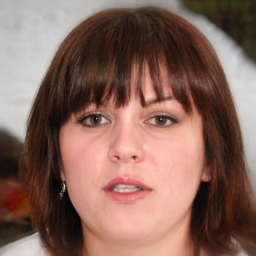

one image


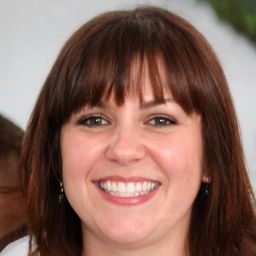

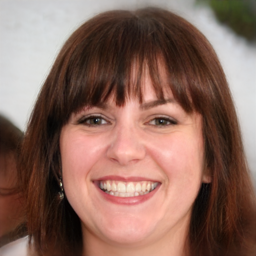

one image
Showing age change


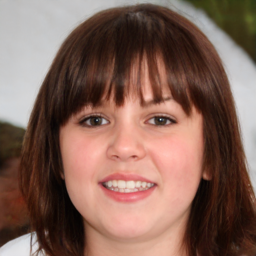

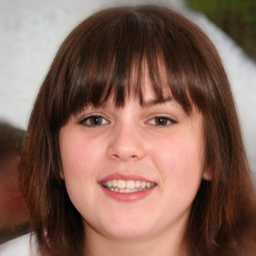

one image


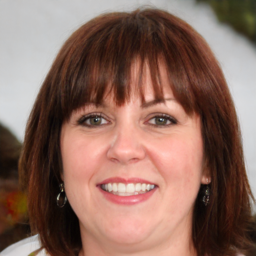

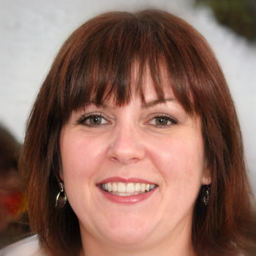

one image


In [ ]:
for direction, factor_and_edit in latents_after_edit.items():
  print(f'Showing {direction} change')
  for keys, latent in factor_and_edit.items():
    old_image = old_G.synthesis(latent, noise_mode='const', force_fp32 = True)
    new_image = new_G.synthesis(latent, noise_mode='const', force_fp32 = True)
    plot_syn_images([old_image, new_image], direction, keys)

## StyleCLIP editing

### Download pretrained models

In [ ]:
mappers_base_dir = '/content/PTI/pretrained_models'

In [ ]:
# More pretrained mappers can be found at: "https://github.com/orpatashnik/StyleCLIP/blob/main/utils.py"
# Download Afro mapper
downloader.download_file("1i5vAqo4z0I-Yon3FNft_YZOq7ClWayQJ", os.path.join(mappers_base_dir, 'afro.pt'))

In [ ]:
# Download Mohawk mapper
downloader.download_file("1oMMPc8iQZ7dhyWavZ7VNWLwzf9aX4C09", os.path.join(mappers_base_dir, 'mohawk.pt'))

In [ ]:
# Download e4e encoder, used for the first inversion step instead on the W inversion.
downloader.download_file("1cUv_reLE6k3604or78EranS7XzuVMWeO", os.path.join(mappers_base_dir, 'e4e_ffhq_encode.pt'))

### Use PTI with e4e backbone for StyleCLIP

In [ ]:
# Changing first_inv_type to W+ makes the PTI use e4e encoder instead of W inversion in the first step
hyperparameters.first_inv_type = 'w+'
os.chdir('/content/PTI')
model_id = run_PTI(use_wandb=False, use_multi_id_training=use_multi_id_training)

Loading e4e over the pSp framework from checkpoint: /content/PTI/pretrained_models/e4e_ffhq_encode.pt
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 1/1 [01:21<00:00, 81.94s/it]


### Apply edit

In [ ]:
from scripts.pti_styleclip import styleclip_edit

In [ ]:
paths_config.checkpoints_dir = '/content/PTI'
os.chdir('/content/PTI')
styleclip_edit(use_multi_id_G=use_multi_id_training, run_id=model_id, edit_types = ['afro'], use_wandb=False)
styleclip_edit(use_multi_id_G=use_multi_id_training, run_id=model_id, edit_types = ['mohawk'], use_wandb=False)

Loading from checkpoint: /content/PTI/pretrained_models/afro.pt
Loading from checkpoint: /content/PTI/pretrained_models/mohawk.pt


In [ ]:
original_styleCLIP_path = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/e4e/{image_name}_afro.jpg'
new_styleCLIP_path  = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/PTI/{image_name}_afro.jpg'
original_styleCLIP = Image.open(original_styleCLIP_path).resize((256,256))
new_styleCLIP =  Image.open(new_styleCLIP_path).resize((256,256))

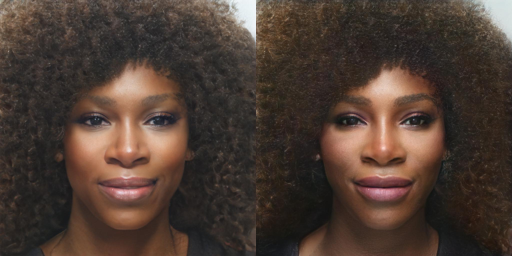

In [ ]:
display_alongside_source_image([original_styleCLIP, new_styleCLIP])

In [ ]:
original_styleCLIP_path = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/e4e/{image_name}_mohawk.jpg'
new_styleCLIP_path  = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/PTI/{image_name}_mohawk.jpg'
original_styleCLIP = Image.open(original_styleCLIP_path).resize((256,256))
new_styleCLIP =  Image.open(new_styleCLIP_path).resize((256,256))

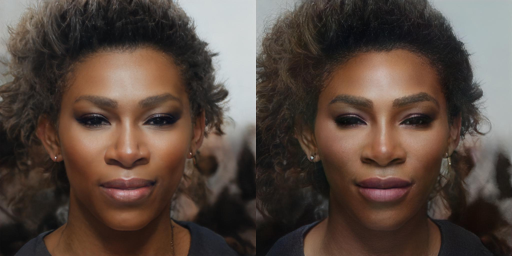

In [ ]:
display_alongside_source_image([original_styleCLIP, new_styleCLIP])

## Other methods comparison

### Invert image using other methods

In [ ]:
from scripts.latent_creators import e4e_latent_creator
from scripts.latent_creators import sg2_latent_creator
from scripts.latent_creators import sg2_plus_latent_creator

In [ ]:
e4e_latent_creator = e4e_latent_creator.E4ELatentCreator()
e4e_latent_creator.create_latents()
sg2_latent_creator = sg2_latent_creator.SG2LatentCreator(projection_steps = 600)
sg2_latent_creator.create_latents()
sg2_plus_latent_creator = sg2_plus_latent_creator.SG2PlusLatentCreator(projection_steps = 1200)
sg2_plus_latent_creator.create_latents()

Loading e4e over the pSp framework from checkpoint: /content/PTI/pretrained_models/e4e_ffhq_encode.pt


100%|██████████| 1/1 [04:39<00:00, 279.23s/it]


In [ ]:
inversions = {}
sg2_embedding_dir = f'{w_path_dir}/{paths_config.sg2_results_keyword}/{image_name}'
inversions[paths_config.sg2_results_keyword] = torch.load(f'{sg2_embedding_dir}/0.pt')
e4e_embedding_dir = f'{w_path_dir}/{paths_config.e4e_results_keyword}/{image_name}'
inversions[paths_config.e4e_results_keyword] = torch.load(f'{e4e_embedding_dir}/0.pt')
sg2_plus_embedding_dir = f'{w_path_dir}/{paths_config.sg2_plus_results_keyword}/{image_name}'
inversions[paths_config.sg2_plus_results_keyword] = torch.load(f'{sg2_plus_embedding_dir}/0.pt')

In [ ]:
def get_image_from_w(w, G):
  if len(w.size()) <= 2:
      w = w.unsqueeze(0) 
  img = G.synthesis(w, noise_mode='const', force_fp32=True) 
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).detach().cpu().numpy() 
  return img[0] 

In [ ]:
def plot_image_from_w(w, G): 
  img = get_image_from_w(w, G) 
  plt.axis('off') 
  resized_image = Image.fromarray(img,mode='RGB').resize((256,256)) 
  display(resized_image) 

Displaying SG2 inversion


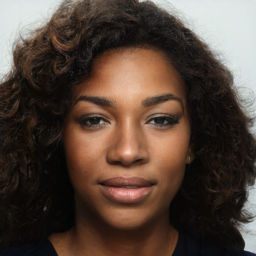

Displaying e4e inversion


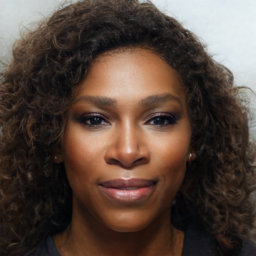

Displaying SG2_plus inversion


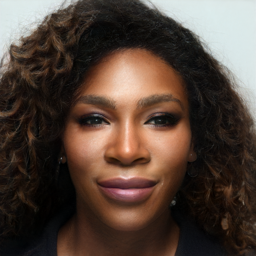

Displaying PTI inversion


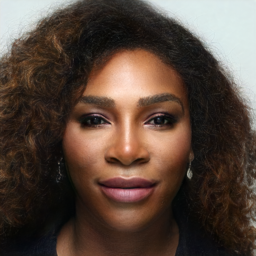

In [ ]:
for inv_type, latent in inversions.items():
  print(f'Displaying {inv_type} inversion')
  plot_image_from_w(latent, old_G)
print(f'Displaying PTI inversion')
plot_image_from_w(w_pivot, new_G)

# SHAP

## Import, Download (FIRST THING TO DO)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 36.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf 
import cv2 
import os
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
import shap

## Preprocess OMI, models

In [ ]:
class_names = {
    0: 'not happy',
    1: 'happy'}

In [ ]:
binary_labels = np.load('young_y.npy')
data_directory = "young100/"
img_size = 224

training_data = []

def create_training_data():
  n = 0
  for img in os.listdir(data_directory):
    n+=1
    try:
      img_array = cv2.imread(os.path.join(data_directory, img))
      new_array = cv2.resize(img_array, (img_size, img_size))
      training_data.append([new_array, binary_labels[n-1]])
    except Exception as e:
      print(f"Error processing image: {os.path.join(data_directory, img)} - {e}")
    
create_training_data()
random.shuffle(training_data)

X = []
y = []
for features, label in training_data:
  X.append(features)
  y.append(label)
X = np.array(X).reshape(-1, img_size, img_size, 3) 
# 3 is the channel for RGB
X = np.array(X).astype(np.float32) / 255.0  # Convert X to numpy array and normalize pixel values
y = np.array(y)

print(len(training_data))
print(X.shape)
print(len(y))

100
(100, 224, 224, 3)
100


In [ ]:
model = tf.keras.applications.MobileNetV2()
base_input = model.layers[0].input
base_output = model.layers[-2].output
final_output = layers.Dense(128)(base_output) 
final_output = layers.Activation('relu')(final_output) 
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(2, activation='softmax')(final_output)
new_model = keras.Model(inputs = base_input, outputs = final_output)
new_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
new_model.fit(X, y, epochs = 10)

14536120/14536120 [==============================] - 0s 0us/step
Epoch 1/10


KeyboardInterrupt: ignored

In [ ]:
new_model.save('omi_young100.h5')

## Load OMI model

In [ ]:
loaded_model = keras.models.load_model('/content/drive/My Drive/omi_young100.h5')

In [ ]:
img_size = 224

sample_data = []

def create_sample_data():
    path = os.path.join('/content/drive//My Drive/age_sample_gan/')
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (img_size, img_size))
            sample_data.append([new_array])
        except:
            print(f"Error processing image: {img}")

create_sample_data()

X_sample = []
for features in sample_data:
    X_sample.append(features)
X_sample = np.array(X_sample).reshape(-1, img_size, img_size, 3)
X_sample = X_sample.astype(np.float32) / 255.0  # Convert X to numpy array and normalize pixel values
print(X_sample.shape)

(3, 224, 224, 3)


In [ ]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return loaded_model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", X_sample[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(f, masker_blur, output_names=[0,1])

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(X_sample, max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:2])

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 3/3 [00:46<00:00, 11.35s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 4it [01:10, 23.35s/it]


In [ ]:
loaded_model.predict(X_sample)

1/1 [==============================] - 1s 1s/step


array([[0.264453  , 0.73554707],
       [0.47004327, 0.5299567 ],
       [0.6032262 , 0.39677382]], dtype=float32)

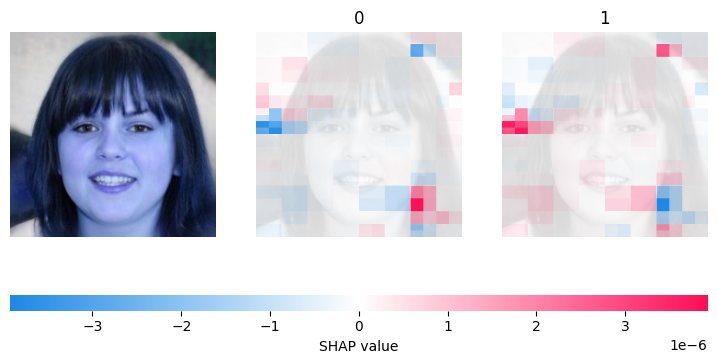

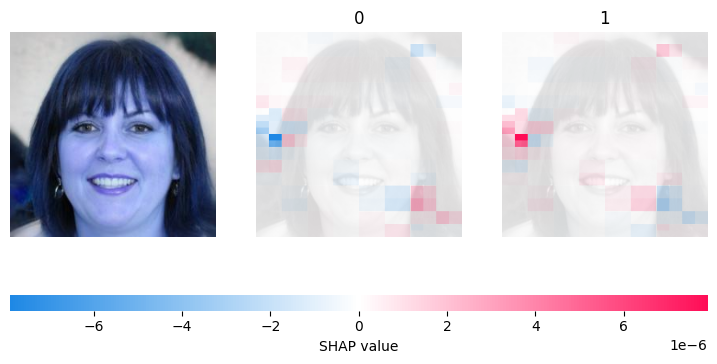

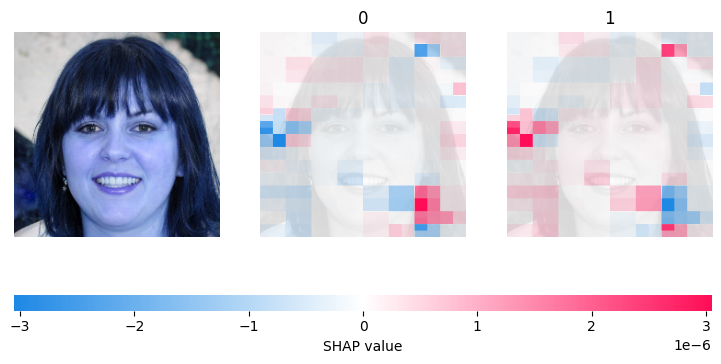

In [ ]:
# Plot the SHAP values, young100
for i in range(len(X_sample)):
  shap.image_plot(shap_values_fine[i])

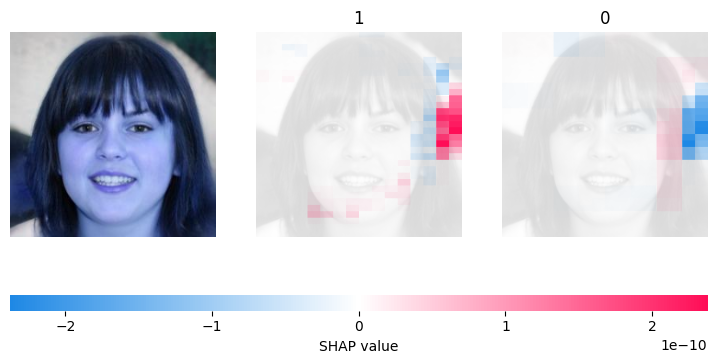

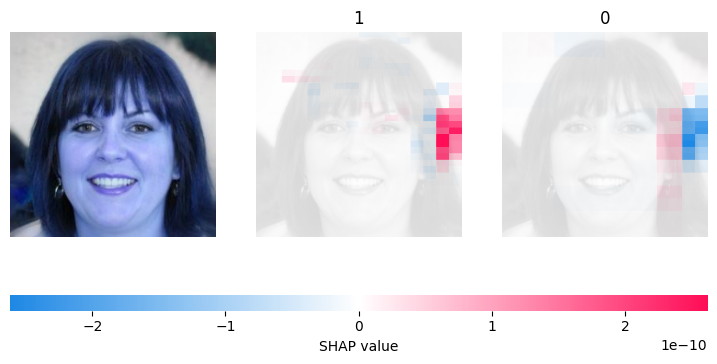

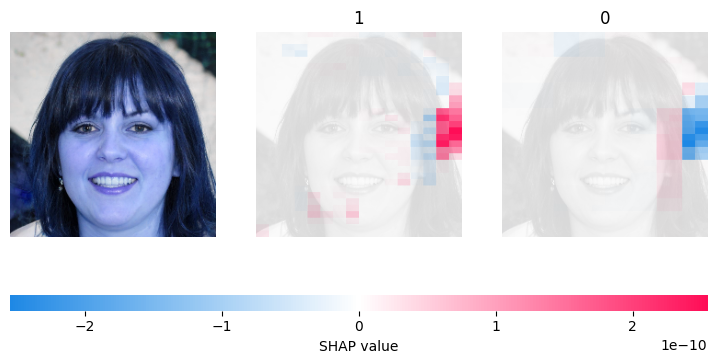

In [ ]:
# Plot the SHAP values, random100
for i in range(len(X_sample)):
  shap.image_plot(shap_values_fine[i])

## Preprocess (fer2013)

Main code reference on creating a tensorflow model:
https://medium.com/analytics-vidhya/realtime-face-emotion-recognition-using-transfer-learning-in-tensorflow-3add4f4f3ff3

In [ ]:
data_directory = "random100/"
classes = [0, 1, 2, 3, 4, 5, 6]

class_names = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

In [ ]:
img_size = 224

training_data = []

def create_training_data():
  for category in class_names:
    path = os.path.join(data_directory, class_names[category])
    class_num = category
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (img_size, img_size))
        training_data.append([new_array, class_num])
      except Exception as e:
        print(f"Error processing image: {os.path.join(path, img)} - {e}")
    
create_training_data()
random.shuffle(training_data)

In [ ]:
X = []
y = []
for features, label in training_data:
  X.append(features)
  y.append(label)
X = np.array(X).reshape(-1, img_size, img_size, 3) 
# 3 is the channel for RGB
X = np.array(X).astype(np.float32) / 255.0  # Convert X to numpy array and normalize pixel values
y = np.array(y)

In [ ]:
print(len(training_data))
print(X.shape)
print(len(y))

7178
(7178, 224, 224, 3)
7178


In [ ]:
save_path = '/content/drive/My Drive/X.npy'
np.save(save_path, X)

In [ ]:
save_path = '/content/drive/My Drive/y.npy'
np.save(save_path, y)

## Model (fer2013 2700 images)
Retried on 3000+, failed

In [ ]:
# Load X and y from the .npy files
X = np.load('X.npy')
y = np.load('y.npy')

print(X.shape)
print(len(y))

(7178, 224, 224, 3)
7178


In [ ]:
model = tf.keras.applications.MobileNetV2()
base_input = model.layers[0].input
base_output = model.layers[-2].output
final_output = layers.Dense(128)(base_output) 
final_output = layers.Activation('relu')(final_output) 
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)
new_model = keras.Model(inputs = base_input, outputs = final_output)
new_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
new_model.fit(X, y, epochs = 20)

14536120/14536120 [==============================] - 1s 0us/step
Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
new_model.save('fer2013test_20epochs.h5')

## Load model

In [ ]:
loaded_model = keras.models.load_model('/content/drive/My Drive/Final_model_95p07.h5')

In [ ]:
classes = [0, 1, 2, 3, 4, 5, 6]
img_size = 224

sample_data = []

def create_sample_data():
    path = os.path.join('/content/drive//My Drive/single_sample_gan/')
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (img_size, img_size))
            sample_data.append([new_array])
        except:
            print(f"Error processing image: {img}")

create_sample_data()

X_sample = []
for features in sample_data:
    X_sample.append(features)
X_sample = np.array(X_sample).reshape(-1, img_size, img_size, 3)
X_sample = X_sample.astype(np.float32) / 255.0  # Convert X to numpy array and normalize pixel values

In [ ]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return loaded_model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", X_sample[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(f, masker_blur, output_names=classes)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(X_sample, max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:7])

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 1/7 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 3/7 [10:44<09:55, 148.98s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 4/7 [15:34<10:23, 207.77s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  71%|███████▏  | 5/7 [20:33<08:03, 241.82s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 6/7 [25:21<04:18, 258.08s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 7/7 [30:15<00:00, 269.78s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 8it [35:05, 300.84s/it]


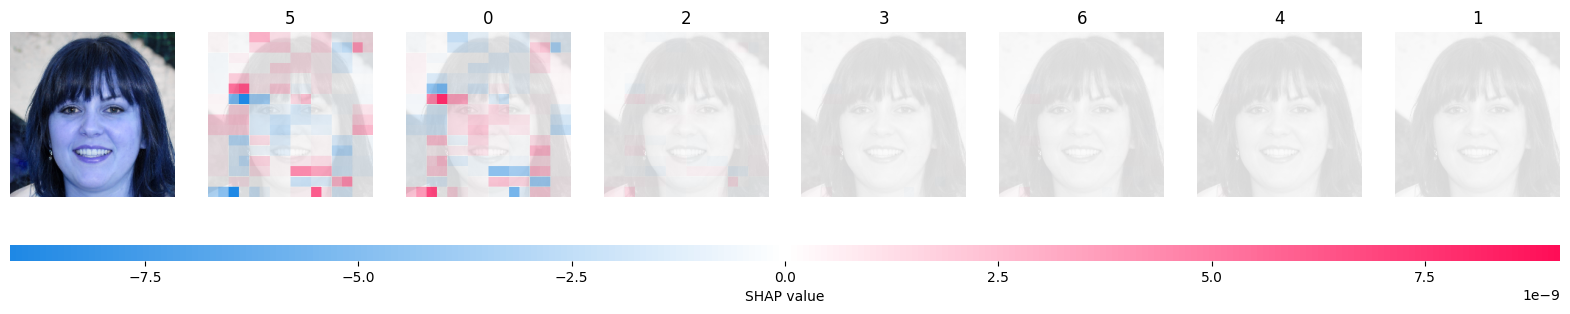

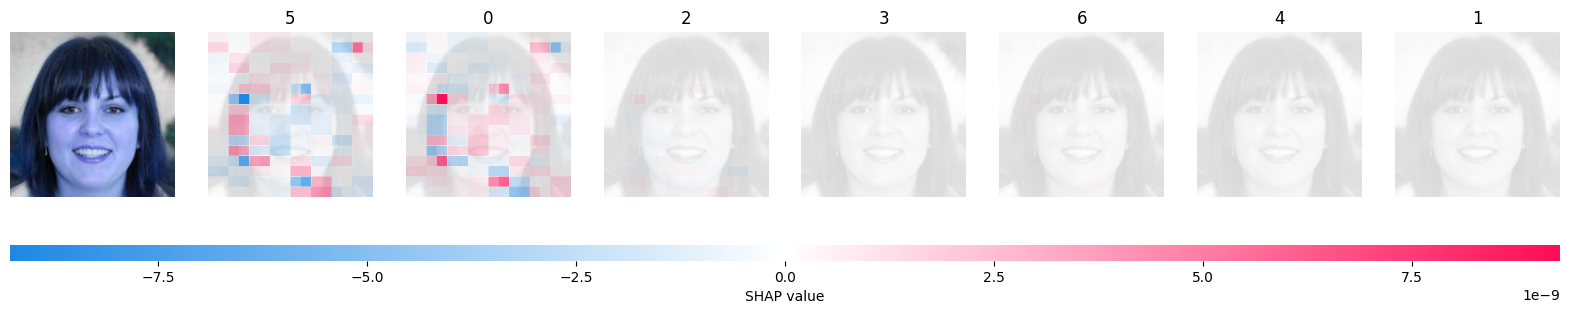

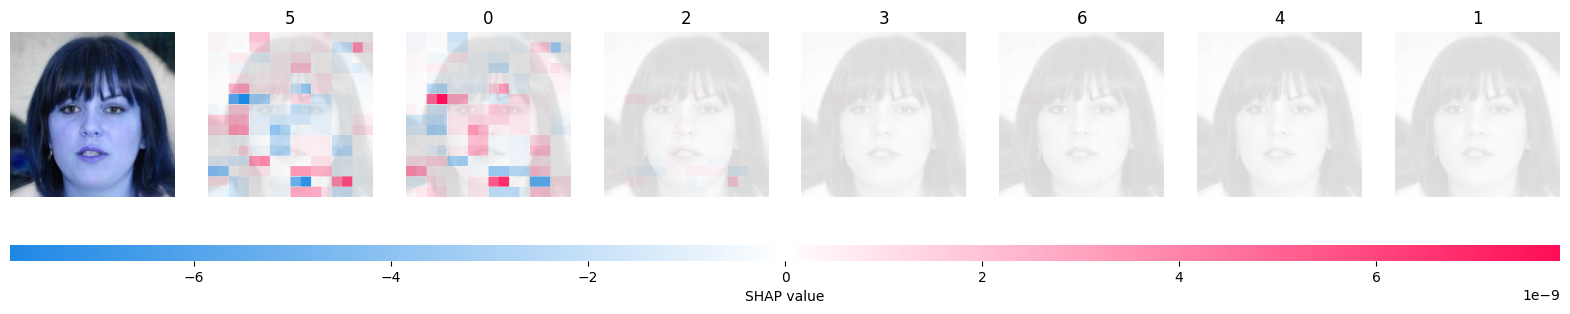

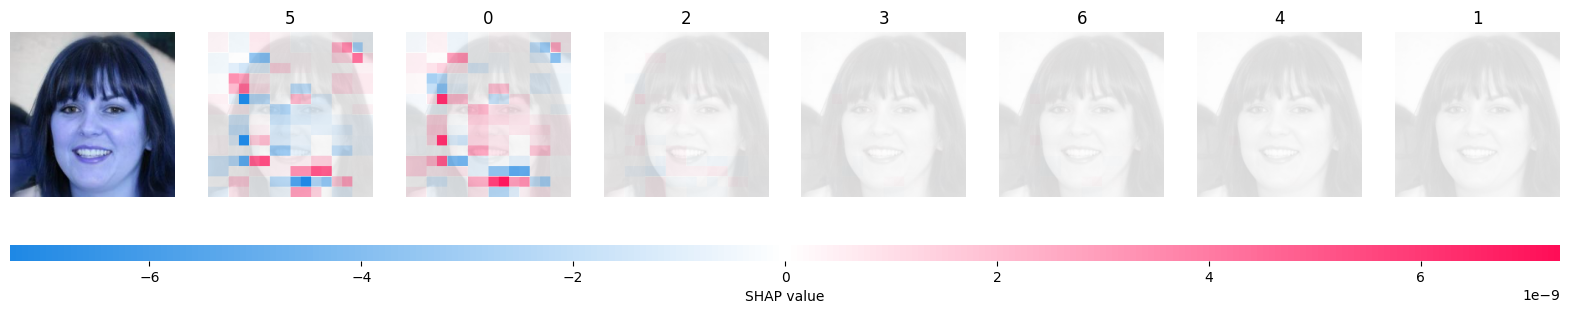

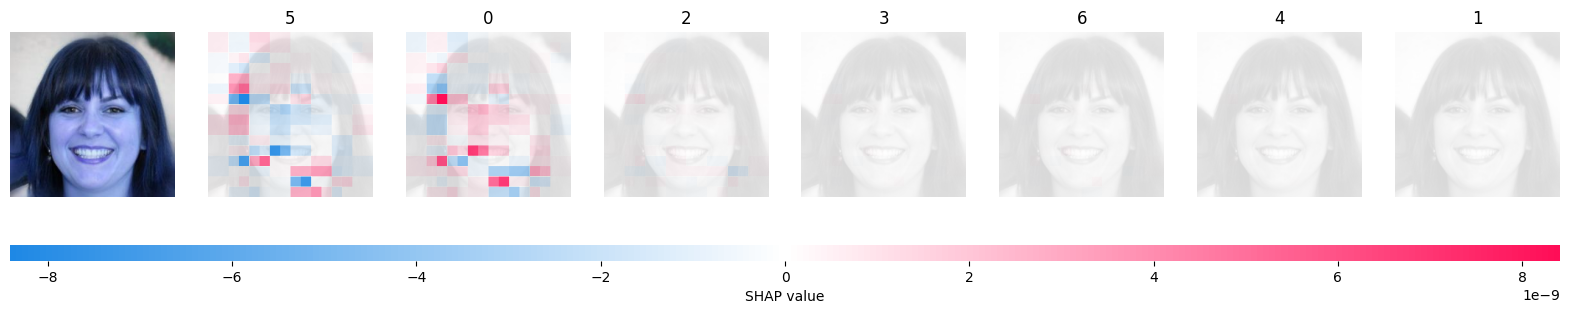

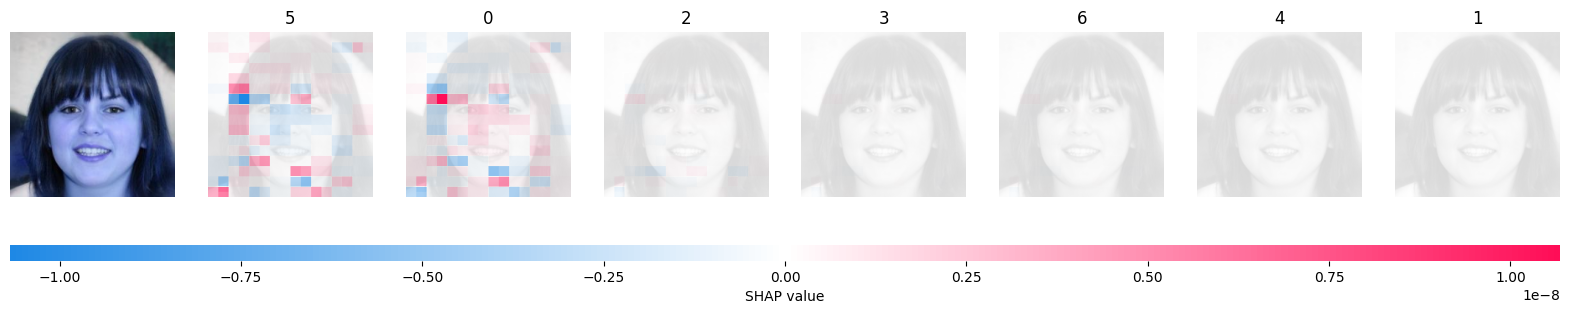

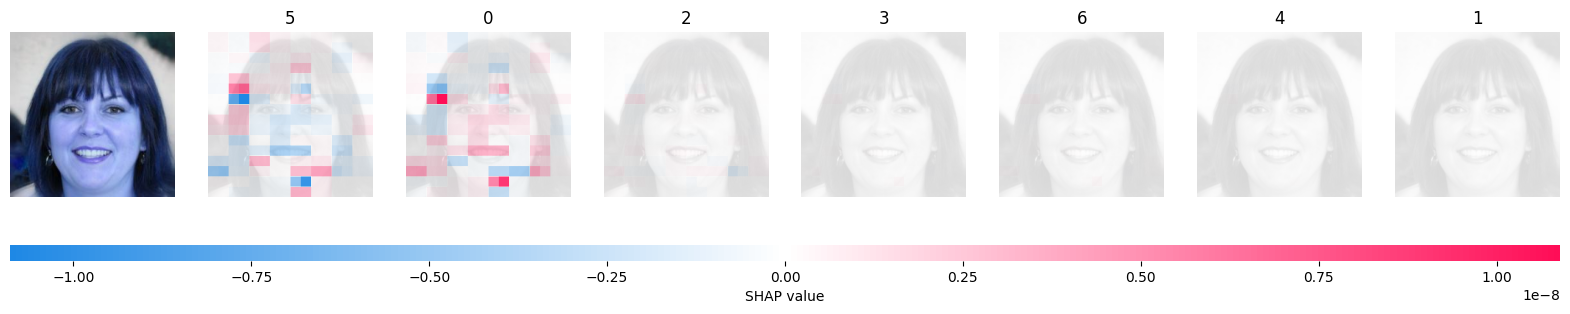

In [ ]:
# Plot the SHAP values, fer2013 model
for i in range(len(X_sample)):
  shap.image_plot(shap_values_fine[i])

In [ ]:
save_path = '/content/drive/My Drive/shap_values_fine.npy'
np.save(save_path, shap_values_fine)

## Previous Visualizations

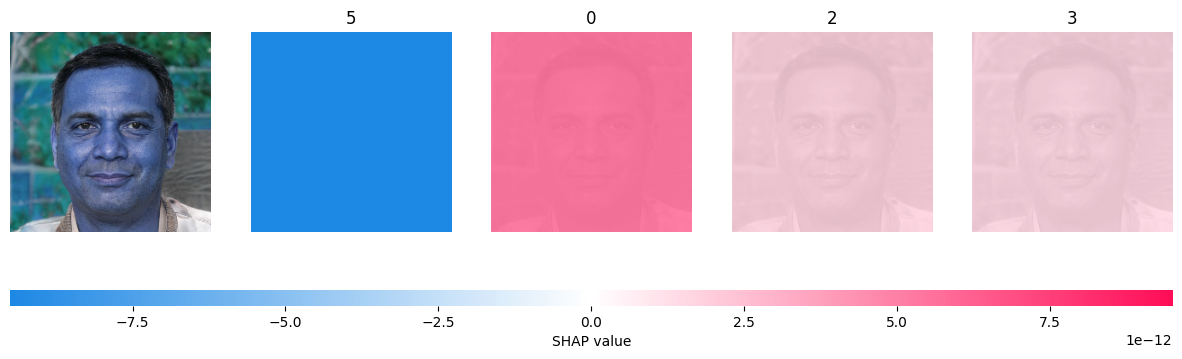

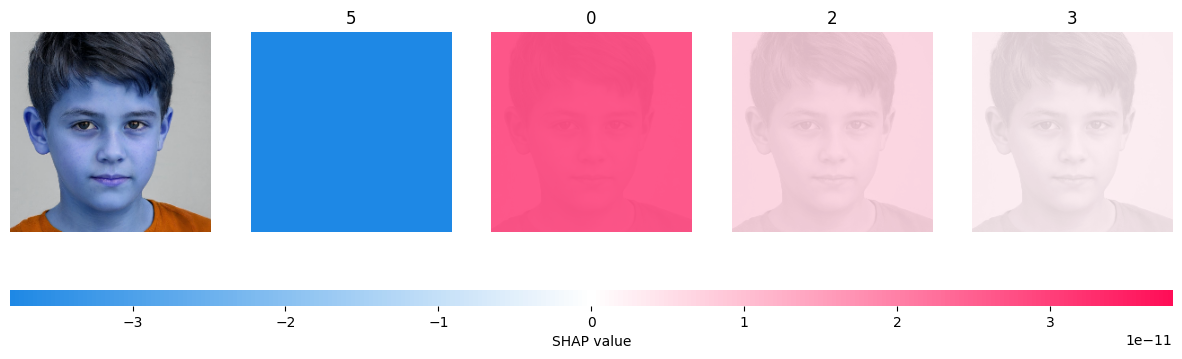

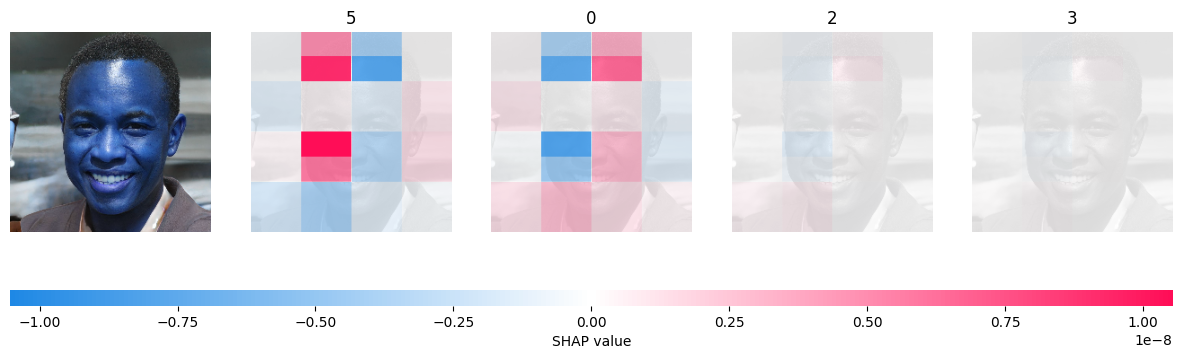

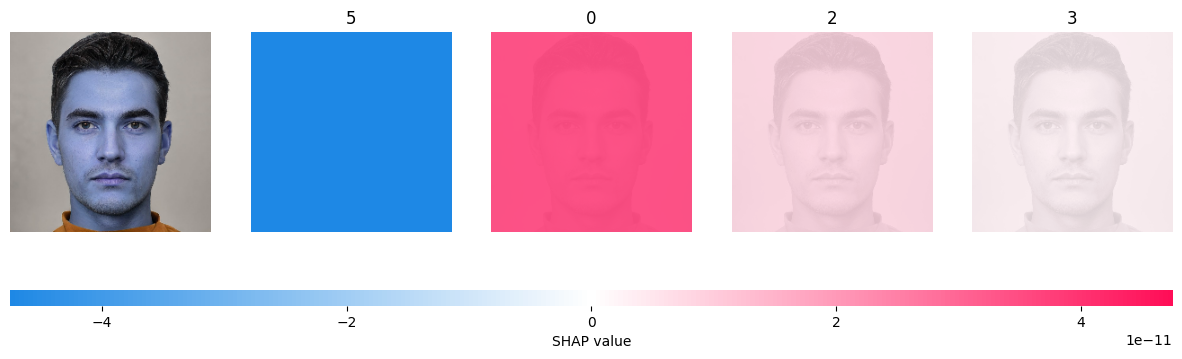

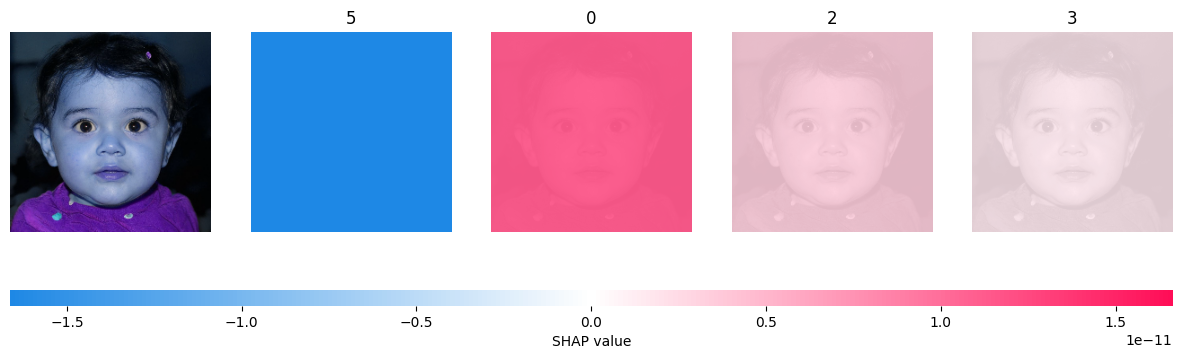

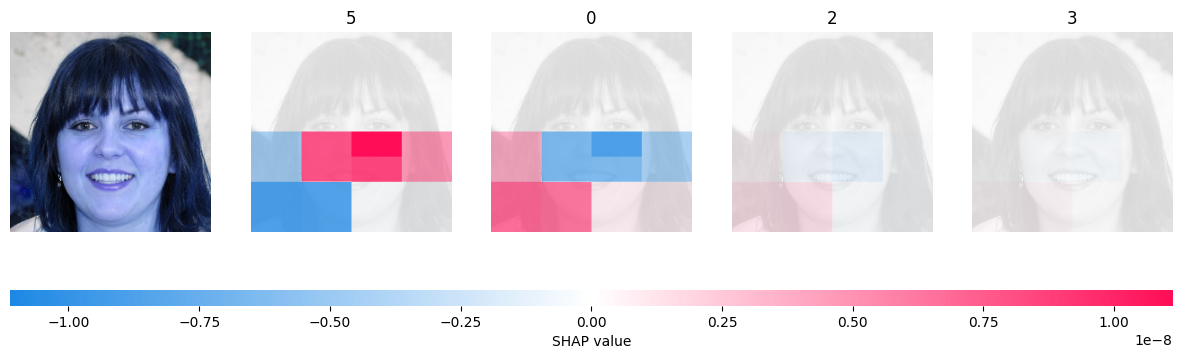

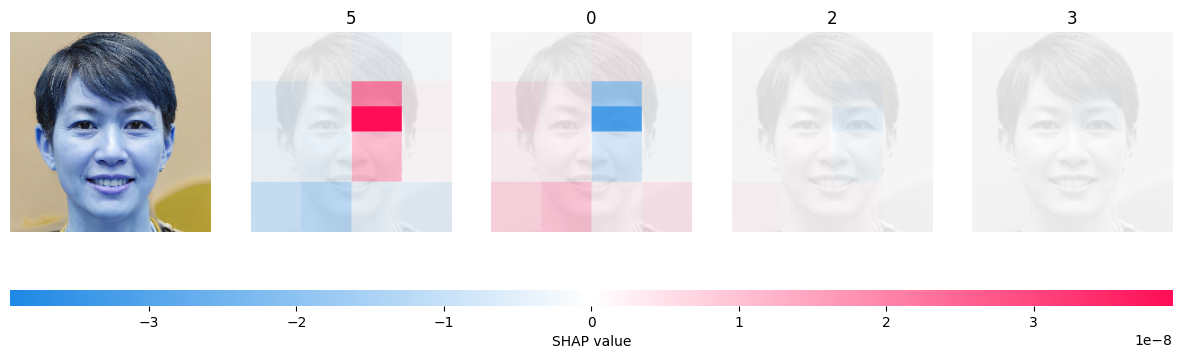

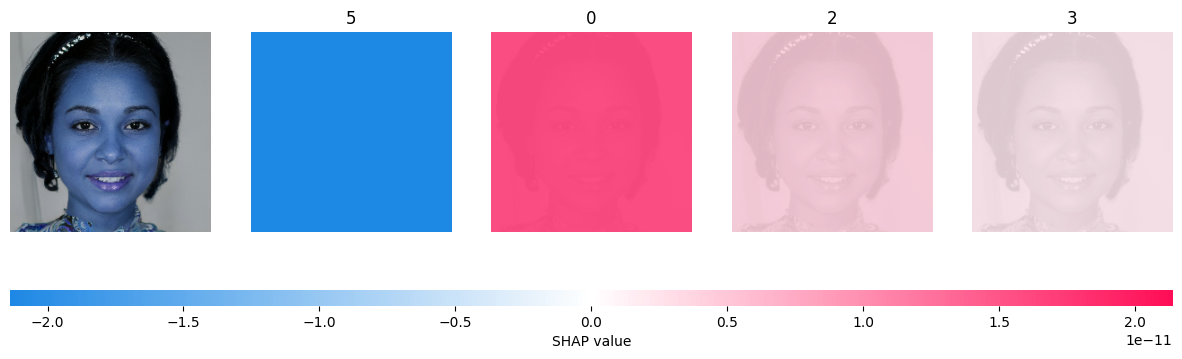

In [ ]:
# Few images from OMI
for i in range(len(X_sample)):
  shap.image_plot(shap_values[i])